# Treinamento de uma spike neural network (SNN)

O presente jupyter notebook contém um passo-a-passo de um treinamento de uma SNN baseada nos neurônios do tipo LIF. O treinamento foi realizado em uma base de dados denominada Spiking Heidelberg Digits (SHD). Tal base contém dados de números de 0 até 9 falados nas línguas alemã e inglesa, totalizando 20 classes. Para chegar a tal resultado, foram utilizadas as bibliotecas Tonic para importar o dataset e a Rockpool, bibioteca que utiliza a API do PyTorch para implementar SNNs. Em particular, a biblioteca da Rockpool foi desenvolvida para faciliatar o deploy da rede em um dos dispositivos ofericidos pela empresa SynSense, como é o caso do chip Xylo.
A implementação foi retirada dos tutoriais:

https://rockpool.ai/basics/hello_MNIST.html

https://rockpool.ai/tutorials/rockpool-shd.html

Bibliotecas

In [1]:
# !pip install tonic
# !pip install rockpool

In [3]:
# Bibliotecas padrão
import numpy as np
import matplotlib.pyplot as plt
import sys

# PyTorch
import torch
import torchvision
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# tqmd para visualização do progresso
from tqdm.autonotebook import tqdm

# Biblioteca com o dataset SHD
import tonic
from tonic import datasets, transforms
from torch.utils.data import DataLoader

# Biblioteca rockpool, para criação da SNN
from rockpool.nn.modules import LIF, LIFTorch, LinearTorch, ExpSynTorch, LIFExodus
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant
from rockpool.utilities.backend_management import backend_available
from rockpool.timeseries import TSEvent

Parâmetros globais

In [4]:
plt.rcParams['figure.figsize'] = [12, 6]

### Exemplo

Simulação de um neurônio ao longo do tempo e sua resposta. São mostrados a corrente, o potencial, a saída e o valor da tensão de limiar ao longo do tempo.

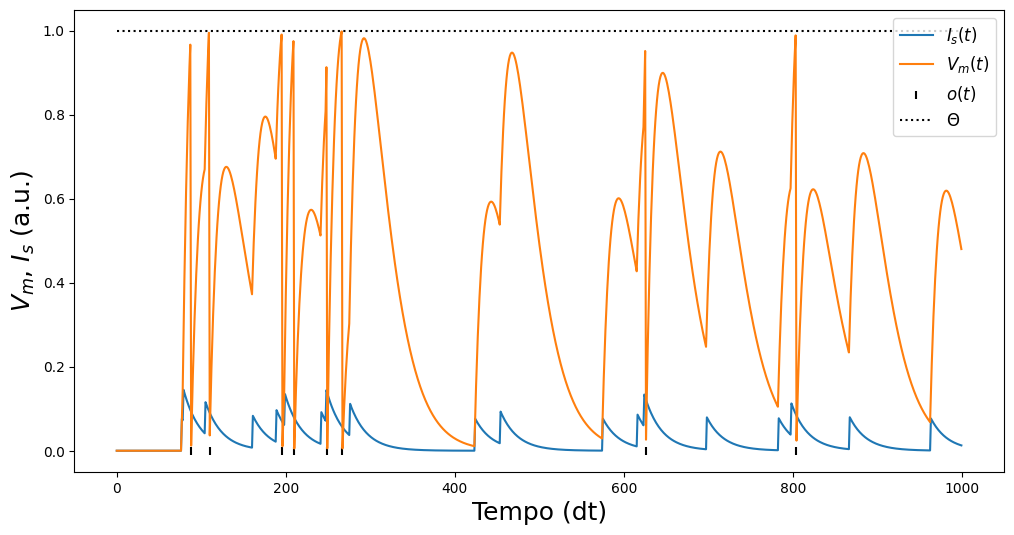

In [5]:
# Criação de um neurônio tipo spike
neuron = LIF(1)

# Simulação do neurônio por 1 s utilizando uma entrada aleatória com valores até 0.08
num_timesteps = int(1/neuron.dt)
input_z = 0.08 * (np.random.rand(num_timesteps) < 0.0125)
output, _, rec_dict = neuron(input_z, record = True)

# Gráfico com os resultados
plt.figure()
plt.plot(rec_dict['isyn'].squeeze(), label = '$I_s(t)$')
plt.plot(rec_dict['vmem'].squeeze(), label = '$V_m(t)$')
b, t, n = np.nonzero(output)
plt.scatter(t, n, marker='|', c = 'k', label = '$o(t)$')
plt.plot([0, num_timesteps], [neuron.threshold] * 2, 'k:', label='$\Theta$')
plt.xlabel('Tempo (dt)', fontsize=18)
plt.ylabel('$V_m$, $I_s$ (a.u.)', fontsize=18)
plt.legend(fontsize=12)
plt.savefig("exemplo_neuronio_parametros.png", dpi=600, bbox_inches='tight')

### Importando os dados

Importando os dados dos conjuntos de treinamento e de teste. Se os dados já estiverem na pasta './data', não será necessário fazer o download novamente.
Também são definidos parâmetros globais da rede, bem como umca classe para modificar os arquivos para terem sempre o mesmo número de pontos (a gravação do som poderia ser de diferentes tamanhos). Por fim, transform realiza o downsample dos dados para terem as mesmas dimensões.

In [6]:
# Parâmetros globais da rede
shd_timestep = 1e-6
shd_channels = 700
net_channels = 20
net_dt = 10e-3
sample_T = 100
batch_size = 256
num_workers = 6

In [7]:
# Classe para uniformizar entradas
class ToRaster():
    def __init__(self, encoding_dim, sample_T = 100):
        self.encoding_dim = encoding_dim
        self.sample_T = sample_T

    def __call__(self, events):
        # Tensor tem dimensões (time_steps, encoding_dim)
        tensor = np.zeros((events["t"].max()+1, self.encoding_dim), dtype=int)
        np.add.at(tensor, (events["t"], events["x"]), 1)
        return tensor[:self.sample_T,:]

In [8]:
# Transformação para aplicar no dataset antes de ser passado para a rede 
transform = transforms.Compose([
        transforms.Downsample(
            time_factor=shd_timestep / net_dt,
            spatial_factor=net_channels / shd_channels
            ),
        ToRaster(net_channels, sample_T = sample_T),
        torch.Tensor,
        ])

In [9]:
# Local de armazenamento dos dados
download_dir='./data'

# Download e importação dos dados, no formato de float
# Treinamento
train_data = datasets.SHD(download_dir, train=True, transform=transforms.NumpyAsType(float))
train_dl = iter(DataLoader(train_data, drop_last=True, shuffle=False))

# Teste
test_data = datasets.SHD(download_dir, train=False, transform=transform)
test_dl = DataLoader(test_data, num_workers=num_workers, batch_size=batch_size,
                          collate_fn=tonic.collation.PadTensors(batch_first=True), drop_last=True, shuffle=False)

Visualização de 3 conjuntos de dados de entrada antes de realizar a transformação (número de entradas = 700)

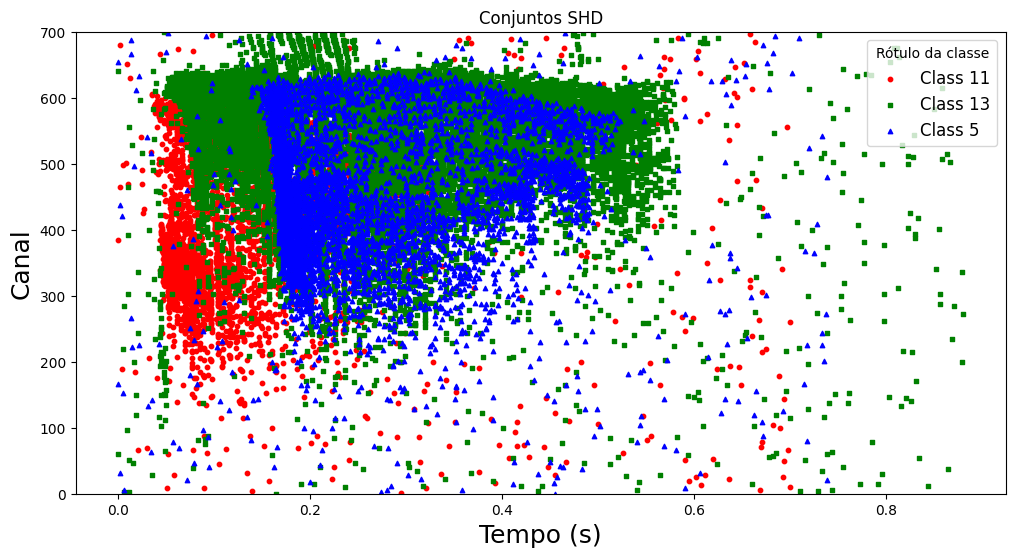

In [10]:
# Extrair os dados para visualização
samples = [next(train_dl) for _ in range(3)]

# Configuração da visualização dos dados
colors = ['r', 'g', 'b']
markers = ['o', 's', '^']  
marker_size = 10 

# Plot
plt.figure()

# Interando sobre os dados
for i, (events, label) in enumerate(samples):
    times = events[0, :, 0]
    event_channels = events[0, :, 1]
    
    # Plot para cada conjunto
    plt.scatter(times.numpy() * 1e-6, event_channels.numpy(), 
                marker=markers[i], color=colors[i], s=marker_size, label=f'Class {label.item()}')

# Configuração do plot
plt.title('Conjuntos SHD')
plt.ylim((0, 700)) # dados com 700 entradas
plt.xlabel('Tempo (s)', fontsize=18)
plt.ylabel('Canal', fontsize=18)
plt.legend(title="Rótulo da classe", fontsize=12)

# Plotar
plt.savefig("entradas_exemplos_pre_transformacao.png", dpi=600, bbox_inches='tight')
plt.show()

Transformação do conjunto de treinamento, passar para a GPU, se existir, e definiçaõ dos parâmetros importantes para o treinamento

In [11]:
# Uso da GPU para treinamento mais rápido, caso disponível
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)

dataloader_kwargs = dict(
    batch_size=256,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=tonic.collation.PadTensors(batch_first=True),
    num_workers=8,
)

train_data = datasets.SHD(download_dir, train=True, transform=transform)

disk_train_dataset = tonic.DiskCachedDataset(
    dataset=train_data,
    cache_path=f"cache/{train_data.__class__.__name__}/train/{net_channels}/{net_dt}",
    reset_cache = True,
)

train_dl = DataLoader(disk_train_dataset, **dataloader_kwargs)

Gráfico das entradas acima após a transformação de 700 features para 20

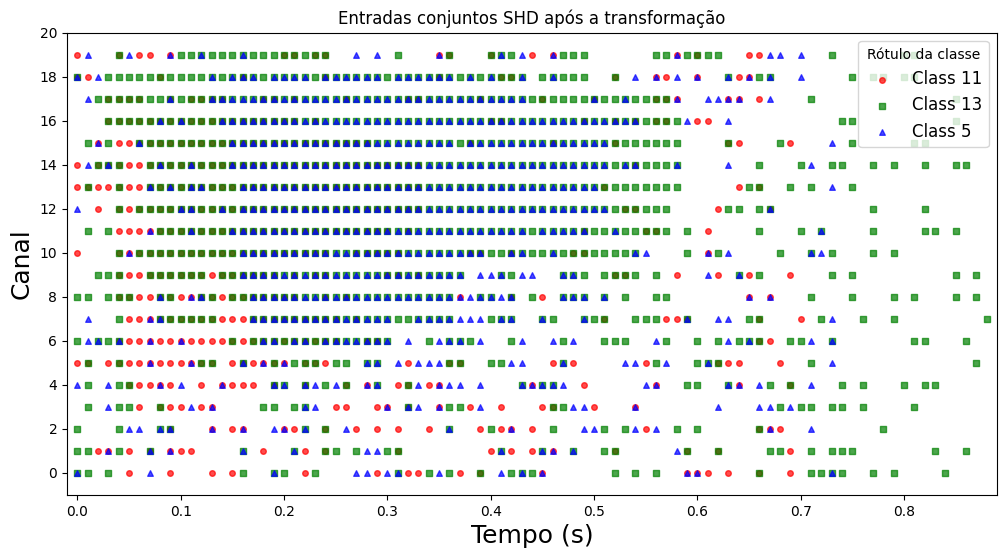

In [12]:
# Parâmetros dos gráficos
colors = ['r', 'g', 'b']
markers = ['o', 's', '^']
marker_size = 16

# Loop nos 3 conjuntos
for i in range(3):
    events, label = disk_train_dataset[i]
    color = colors[i]
    
    # Loop para achar cada ponto com um valor maior que 0 (spike)
    for outer_idx, inner_vector in enumerate(events):
        inner_x = np.full_like(inner_vector, outer_idx)
        inner_y = np.arange(len(inner_vector))
        
        # Filtragem posições em que a posição é maior que 0
        mask = inner_vector > 0
        plt.scatter(
            inner_x[mask]*net_dt,  
            inner_y[mask],  
            color=color,    
            marker=markers[i],
            s=marker_size,
            label=f'Class {label.item()}' if outer_idx == 0 else None,
            alpha=0.7
        )

# Configurações do gráficos
plt.xlim(-0.01, 0.89)
plt.ylim(-1, 20)
plt.yticks(np.arange(0, 21, 2))
plt.title("Entradas conjuntos SHD após a transformação")
plt.xlabel("Tempo (s)", fontsize=18)
plt.ylabel("Canal", fontsize=18)
plt.legend(title="Rótulo da classe", fontsize=12)
plt.savefig("entradas_exemplos_pos_transformacao.png", dpi=600, bbox_inches='tight')
plt.show()

Um conjunto de entrada e seu alvo de saída (exemplo do conjunto de treinamento)

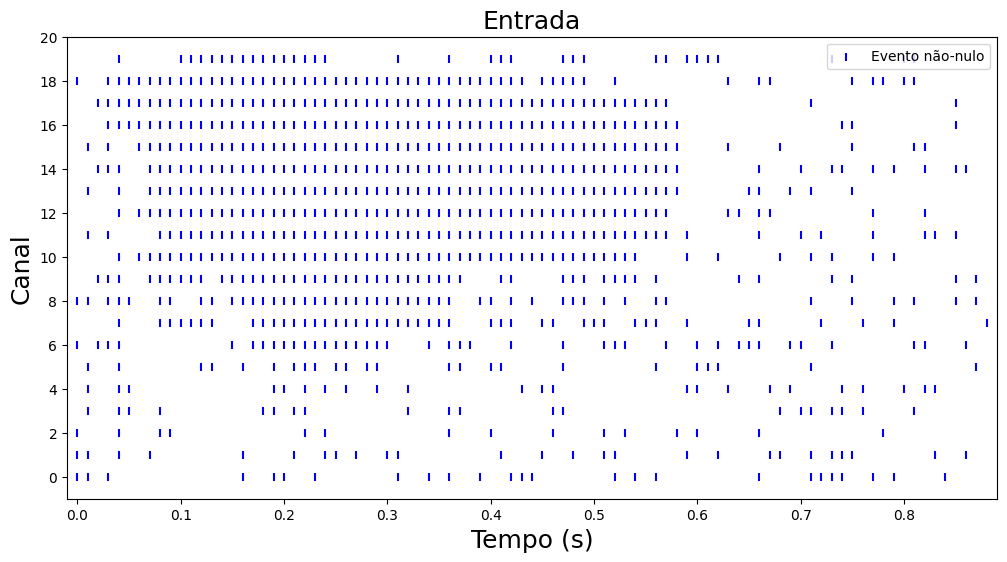

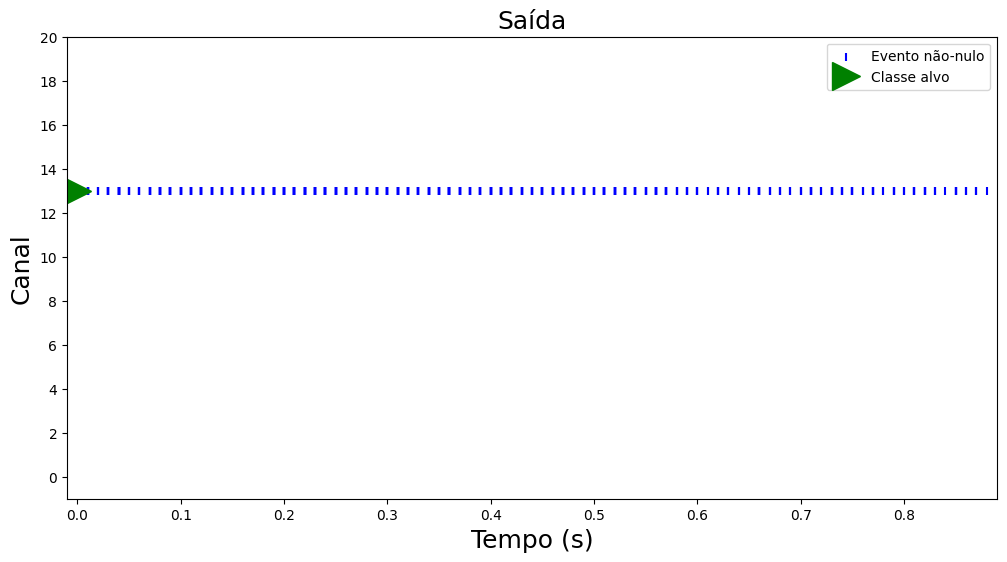

In [13]:
# Teste único
frame, class_idx = train_data[1]
data = frame

# Posições em que temos entradas na rede não nulas
x, y = torch.nonzero(data > 0, as_tuple=True)

# Mostrar essas posições
plt.scatter(x*net_dt, y, marker='|', color='b', label='Evento não-nulo')

# Configurações do gráfico
plt.xlabel('Tempo (s)', fontsize = 18)
plt.ylabel('Canal', fontsize = 18)
plt.title('Entrada', fontsize = 18)
plt.xlim(-0.01, 0.89)
plt.ylim(-1, 20)
plt.yticks(np.arange(0, 21, 2))
plt.legend()

# Salvar a figura
plt.savefig("entrada_exemplo.png", dpi=600, bbox_inches='tight')
plt.show()

##############################################

plt.scatter(x*net_dt, x*0 + class_idx, marker='|', color='b', label='Evento não-nulo')
plt.plot(0, class_idx, 'g>', markersize=20, label='Classe alvo')
plt.ylim([-1, 20+1])
plt.xlabel('Tempo (s)', fontsize = 18)
plt.ylabel('Canal', fontsize = 18)
plt.title('Saída', fontsize = 18)
plt.xlim(-0.01, 0.89)
plt.ylim(-1, 20)
plt.yticks(np.arange(0, 21, 2))
plt.legend()

plt.savefig("saida_exemplo_classe_alvo.png", dpi=600, bbox_inches='tight')
plt.show()

### Definição da rede e treinamento

In [14]:
# Modelo do neurônio
NeuronModel = LIFExodus if backend_available('sinabs-exodus') and torch.cuda.is_available() else LIFTorch

# Definição da rede
def SimpleNet(Nin, Nhidden, Nout):
    return Sequential(
        LinearTorch((Nin, Nhidden), has_bias=False),
        NeuronModel(Nhidden,
            tau_mem=Constant(100e-3),
            tau_syn=Constant(100e-3),
            threshold=Constant(1.),
            bias=Constant(0.),
            dt=net_dt,
            has_rec=False),
        LinearTorch((Nhidden, Nout), has_bias = False),
        ExpSynTorch(Nout, dt=net_dt, tau=Constant(5e-3))
    )

In [15]:
# Construção da rede
Nin = net_channels
Nhidden = 20
Nout = 20

torch.manual_seed(1234) # Uma semente para definir de maneira reprodutível o estado inicial da rede

net = SimpleNet(Nin, Nhidden, Nout).to(device)
print(net)

TorchSequential  with shape (20, 20) {
    LinearTorch '0_LinearTorch' with shape (20, 20)
    LIFTorch '1_LIFTorch' with shape (20, 20)
    LinearTorch '2_LinearTorch' with shape (20, 20)
    ExpSynTorch '3_ExpSynTorch' with shape (20,)
}


Definição de parâmetros para o treinamento

In [16]:
# Função de otimização
optimizer = Adam(net.parameters().astorch(), lr=1e-3)

# Função de perda
loss_fun = CrossEntropyLoss()

# Vetores para gravar os valores durante o treinamento
accuracy = []
loss_t = []
num_epochs = 1000

Treinamento

In [17]:
# Loop do treinamento
with tqdm(range(num_epochs), unit = 'Epoch', desc = 'Training') as pbar:
    for _ in pbar:
        correct = 0
        total_loss = 0
        total = 0
        temp_loss = 0

        net.train()

        for events, labels in train_dl:
            events, labels = events.to(device), labels.to(device)
            optimizer.zero_grad()

            output, _, _ = net(events)

            sum = torch.cumsum(output, dim=1)

            loss = loss_fun(sum[:,-1,:], labels)

            loss.backward()
            optimizer.step()

            # Cálculo do número de respostas corretas
            predicted = torch.argmax(sum[:,-1,:], 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            this_loss = loss.item()

        # Salvando a acurácia do modelo
        this_accuracy = (correct/total)*100
        accuracy.append(this_accuracy)
        loss_t.append(this_loss)
        pbar.set_postfix(Loss = f'{this_loss:.2f}', Accuracy = f'{this_accuracy:.0f}%')

print(f"Training Accuracy: {accuracy[-1]:.3f}%")

Training: 100%|█| 1000/1000 [2:18:16<00:00,  8.30s/Epoch, Accuracy=79%, Loss=0.7

Training Accuracy: 78.553%


### Análise dos dados

Gerando o gráfico da função de perda e acurácia do modelo

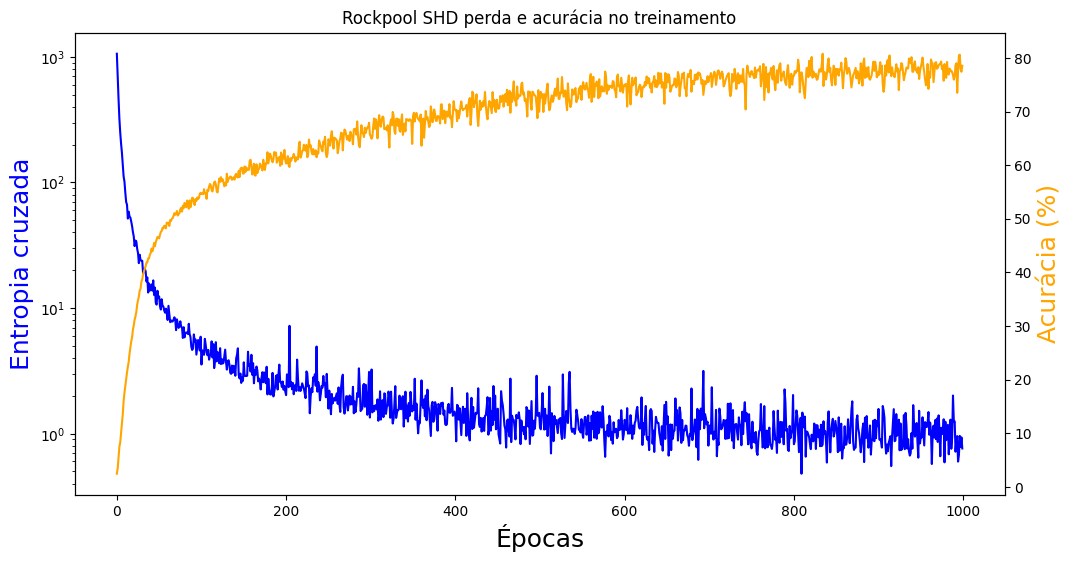

In [21]:
# Plot função de perda e acurácia no treinamento
fig, ax = plt.subplots()
ax.plot(loss_t, color='blue')
ax.set_ylabel('Entropia cruzada', color='blue', fontsize=18)
ax.set_yscale('log')
ax.set_xlabel('Épocas', fontsize=18)

ax2 = ax.twinx()
ax2.plot(accuracy, color='orange')
ax2.set_ylabel('Acurácia (%)', color='orange', fontsize=18)
ax2.set_yscale('linear')

plt.title('Rockpool SHD perda e acurácia no treinamento')

plt.savefig("acuracia_treinamento.png", dpi=600, bbox_inches='tight')
plt.show()

Resultado final do modelo, considerando seu desempenho no conjunto de teste

In [19]:
# Loop de teste:
net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    total_loss = 0

    for events, labels in test_dl:
        events, labels = events.to(dev), labels.to(dev)
        output, _, _ = net(torch.Tensor(events).float())

        sum = torch.cumsum(output, dim=1)

        predicted = torch.argmax(sum[:,-1,:], 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy_test = (correct/total)*100

print(f"Test Accuracy: {accuracy_test:.3f}%")

Test Accuracy: 61.279%


Exemplo de uma saída, o valor predito e o valor alvo esperado (pós-treinamento)

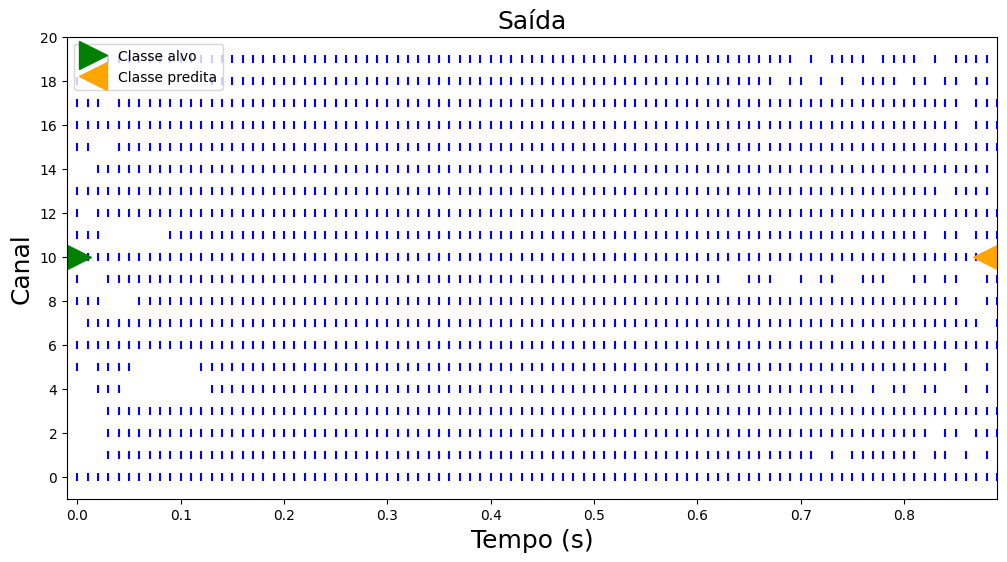

In [20]:
i = 0 
for events, labels in train_dl:
    events, labels = events.to(dev), labels.to(dev)
    output, _, _ = net(torch.Tensor(events).float())

    # Como o batch tem 256 entradas, vamos retirar apenas uma de exemplo
    first_position = output[0]

    # Loop sobre todo o tempo
    for x in range(first_position.shape[0]):
        values = first_position[x]
        # Encontrar as saídas que estão sendo ativadas
        y_positions = torch.nonzero(values > 0, as_tuple=False).squeeze()
        
        # Plota uma marca 'y' em cada uma dessas saídas
        plt.scatter([x*net_dt] * len(y_positions), y_positions, color='b', marker='|')

    sum = torch.cumsum(output, dim=1)
    predicted = torch.argmax(sum[:,-1,:], 1)

    plt.plot(0, labels[0], 'g>', markersize=20, label='Classe alvo')
    plt.plot(0.88, predicted[0], '<', c='orange', markersize=20, label='Classe predita')
    plt.ylim([-1, 20+1])
    plt.xlabel('Tempo (s)', fontsize = 18)
    plt.ylabel('Canal', fontsize = 18)
    plt.title('Saída', fontsize = 18)
    plt.xlim(-0.01, 0.89)
    plt.ylim(-1, 20)
    plt.yticks(np.arange(0, 21, 2))
    plt.legend()

    plt.savefig("saida_exemplo_treinada.png", dpi=600, bbox_inches='tight')
    
    i = i + 1
    if i == 1:
        break